In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import dates
from netCDF4 import num2date,date2num,Dataset
import scipy.interpolate as interpolate
import pyproj
import os, subprocess, time, copy
from joblib import Parallel, delayed
import datetime
import cPickle as pickle
from mpl_toolkits.basemap import Basemap
import mahotas, pymorph, pylab
import scipy.ndimage as ndi
import matplotlib.gridspec as gridspec
from math import radians, sin, cos, sqrt, asin
from matplotlib.colors import LogNorm
from netCDF4 import num2date,date2num,Dataset
import matplotlib._pylab_helpers
#from joblib import Parallel, delayed
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats.mstats import scoreatpercentile
import scipy
#import math
import cPickle as pickle
import pandas as pd
#import pickle
import pprint
import csv
import pysal
from marcus_py_tools import walklevel, make_edge_vec, xy_from_latlon, latlon_from_xy, haversine
%matplotlib inline

In [150]:
#filenm = '/home/mvanlier/mvanlier/mrdss/out_mrdss/LES_to_DS_marcus_018000_sgpk.nc'
filenm = '/home/mvanlier/mvanlier/mrdss/out_mrdss/LES_to_DS_marcus_021600_sgpk.nc'
nc = Dataset(filenm,'r')
xd = nc.variables['x'][:]
yd = nc.variables['y'][:]
zd = nc.variables['z'][:]
zrd = nc.variables['zr'][:]
dbz_mie = nc.variables['dBZ_mie'][:,:,:]    #..nz,ny,nx
spc_wid = nc.variables['Width'][:,:,:]
mdv     = nc.variables['Velo'][:,:,:]
dbz_sim = nc.variables['dBZ_sim_rad'][:,:,:]
mdv_sim = nc.variables['Velo_rad'][:,:,:]
nc.close()
dbz_mie = np.ma.masked_where(np.isinf(dbz_mie),dbz_mie)

In [137]:
print dbz_mie.shape
print dbz_sim.shape
print zd.shape
xidx = 7
yidx = 20
zidx = 64
print dbz_mie[zidx,yidx,xidx]
print mdv[zidx,yidx,xidx]

(145, 128, 128)
(164, 128, 128)
(145,)
-65.623783424
2.39791476818


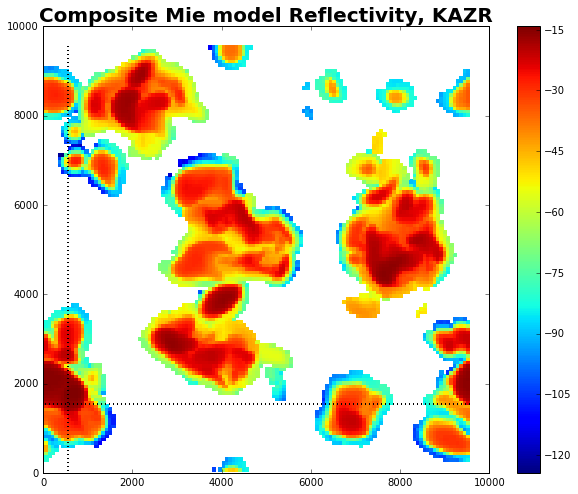

In [83]:
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.pcolormesh(xd,yd,dbz_mie[:,:,:].max(axis=0))
plt.plot([xd[0],xd[-1]],[yd[yidx],yd[yidx]],'k:',lw=2)
plt.plot([xd[xidx],xd[xidx]],[yd[0],yd[-1]],'k:',lw=2)
#plt.pcolormesh(xd,yd,dbz_mie[60,:,:])
plt.title('Composite Mie model Reflectivity, KAZR',fontsize=20,fontweight='bold')
plt.colorbar()

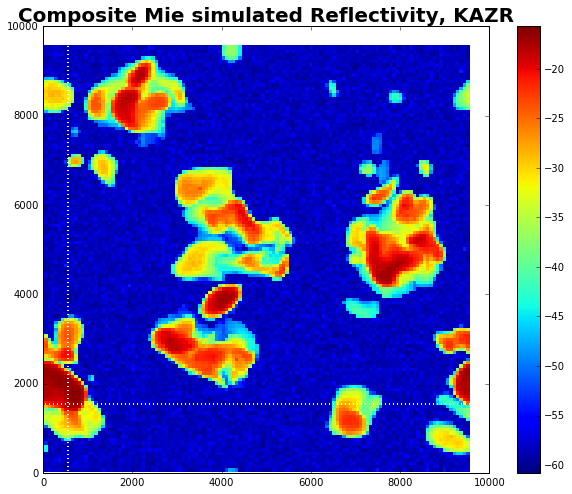

In [84]:
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.pcolormesh(xd,yd,dbz_sim[:,:,:].max(axis=0))
plt.plot([xd[0],xd[-1]],[yd[yidx],yd[yidx]],'w:',lw=2)
plt.plot([xd[xidx],xd[xidx]],[yd[0],yd[-1]],'w:',lw=2)
#plt.pcolormesh(xd,yd,dbz_sim[60,:,:])
plt.title('Composite Mie simulated Reflectivity, KAZR',fontsize=20,fontweight='bold')
plt.colorbar()

(37.5, 9562.5)

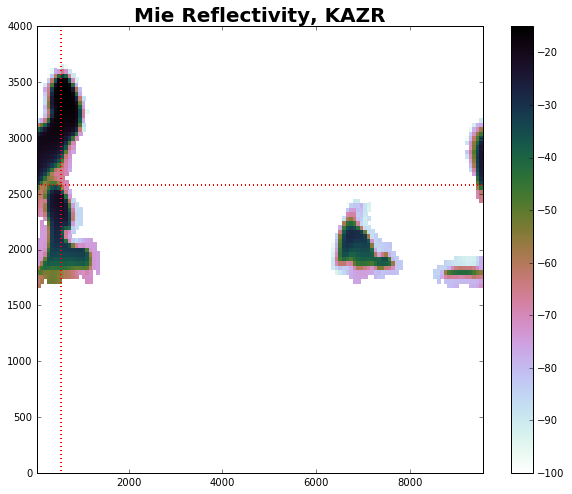

In [85]:
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
#plt.pcolormesh(xd,yd,dbz_mie[:,:,:].max(axis=0))
plt.pcolormesh(xd,zd,dbz_mie[:,yidx,:],vmin=-100,vmax=-15.,cmap=cm.cubehelix_r)
plt.plot([xd[xidx],xd[xidx]],[zd[0],zd[-1]],'r:',lw=2)
plt.plot([xd[0],xd[-1]],[zd[zidx],zd[zidx]],'r:',lw=2)
plt.colorbar()
plt.title('Mie Reflectivity, KAZR',fontsize=20,fontweight='bold')
ax.set_ylim(0.,4000.)
ax.set_xlim(xd.min(),xd.max())

(37.5, 9562.5)

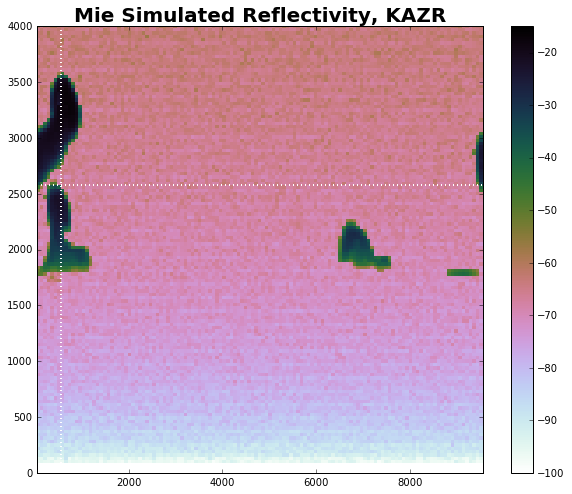

In [86]:
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
#plt.pcolormesh(xd,yd,dbz_mie[:,:,:].max(axis=0))
plt.pcolormesh(xd,zrd,dbz_sim[:,yidx,:],vmin=-100,vmax=-15.,cmap=cm.cubehelix_r)
plt.plot([xd[xidx],xd[xidx]],[zd[0],zd[-1]],'w:',lw=2)
plt.plot([xd[0],xd[-1]],[zd[zidx],zd[zidx]],'w:',lw=2)
plt.colorbar()
plt.title('Mie Simulated Reflectivity, KAZR',fontsize=20,fontweight='bold')
ax.set_ylim(0.,4000.)
ax.set_xlim(xd.min(),xd.max())

(37.5, 9562.5)

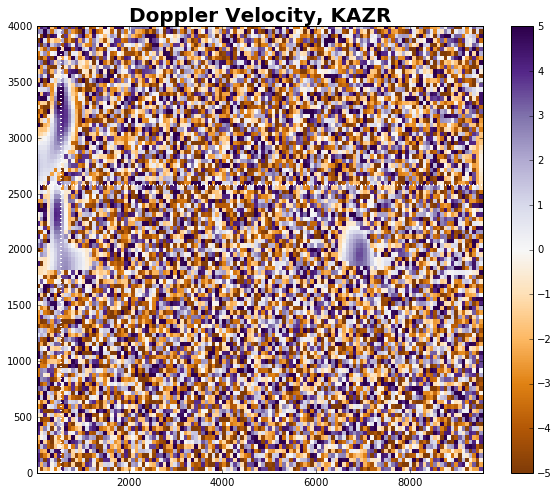

In [87]:
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
#plt.pcolormesh(xd,yd,dbz_mie[:,:,:].max(axis=0))
mdv_proc = np.ma.masked_where(dbz_mie<-60.,mdv)
#plt.pcolormesh(xd,zd,mdv_proc[:,55,:],cmap=cm.PuOr,vmin=-5,vmax=5)
plt.pcolormesh(xd,zd,mdv[:,yidx,:],cmap=cm.PuOr,vmin=-5,vmax=5)
plt.plot([xd[xidx],xd[xidx]],[zd[0],zd[-1]],'w:',lw=2)
plt.plot([xd[0],xd[-1]],[zd[zidx],zd[zidx]],'w:',lw=2)
plt.colorbar()
plt.title('Doppler Velocity, KAZR',fontsize=20,fontweight='bold')
ax.set_ylim(0.,4000.)
ax.set_xlim(xd.min(),xd.max())

In [89]:
print mdv.max(), mdv.min()
#print mdv[]

5.88251767647 -5.96639477738


(37.5, 9562.5)

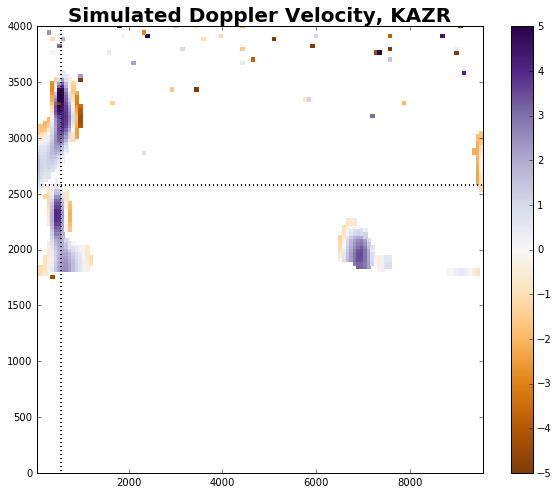

In [90]:
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
#plt.pcolormesh(xd,yd,dbz_mie[:,:,:].max(axis=0))
mdv_sim_proc = np.ma.masked_where(dbz_sim<-60.,mdv_sim)
plt.pcolormesh(xd,zrd,mdv_sim_proc[:,yidx,:],cmap=cm.PuOr,vmin=-5,vmax=5)
plt.plot([xd[xidx],xd[xidx]],[zd[0],zd[-1]],'k:',lw=2)
plt.plot([xd[0],xd[-1]],[zd[zidx],zd[zidx]],'k:',lw=2)
#plt.pcolormesh(xd,zrd,mdv_sim[:,55,:],cmap=cm.PuOr,vmin=-5,vmax=5)
plt.colorbar()
plt.title('Simulated Doppler Velocity, KAZR',fontsize=20,fontweight='bold')
ax.set_ylim(0.,4000.)
ax.set_xlim(xd.min(),xd.max())


(37.5, 9562.5)

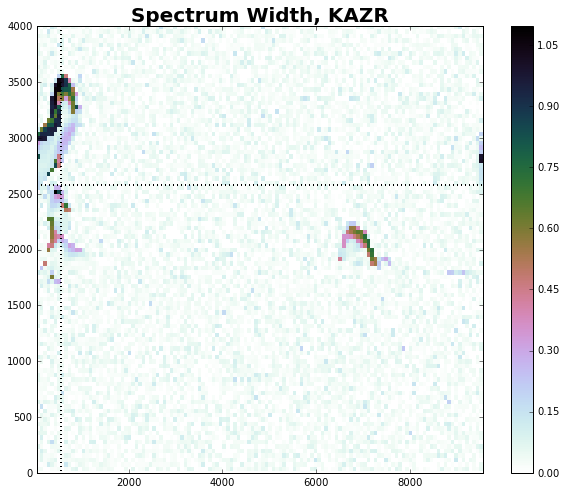

In [91]:
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
#plt.pcolormesh(xd,yd,dbz_mie[:,:,:].max(axis=0))
mdv_sim_proc = np.ma.masked_where(dbz_sim<-60.,mdv_sim)
plt.pcolormesh(xd,zd,spc_wid[:,yidx,:],cmap=cm.cubehelix_r)
plt.plot([xd[xidx],xd[xidx]],[zd[0],zd[-1]],'k:',lw=2)
plt.plot([xd[0],xd[-1]],[zd[zidx],zd[zidx]],'k:',lw=2)
#plt.pcolormesh(xd,zrd,mdv_sim[:,55,:],cmap=cm.PuOr,vmin=-5,vmax=5)
plt.colorbar()
plt.title('Spectrum Width, KAZR',fontsize=20,fontweight='bold')
ax.set_ylim(0.,4000.)
ax.set_xlim(xd.min(),xd.max())

In [144]:
filenm = '/home/afridlin/raid/runs/racoro/may22_hm_128x128x145_9.6x15km_va_relax_bin_day1/marcus_018000.cdf'
nc = Dataset(filenm,'r')
P = nc.variables['P'][:]
T = nc.variables['T'][:,:,:]
qv = nc.variables['qv'][:,:,:]
nd = nc.variables['dN_drops'][:,zidx-1,yidx-1,xidx-1]
vfall = nc.variables['vfall_drops'][:,zidx-1]
D  = 2.*nc.variables['r_drops'][:]
De = 2.*nc.variables['rbound_drops'][:]
nc.close()
print P[zidx-1]
print T[zidx-1,yidx-1,xidx-1]
print qv[zidx-1,yidx-1,xidx-1]
print qv.shape

72509.5
278.288
0.00765426
(145, 128, 128)


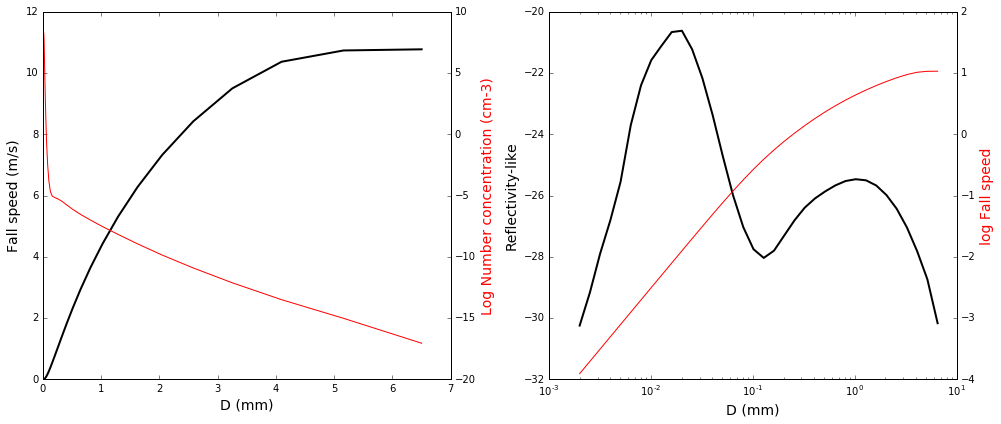

In [141]:
fig = plt.figure(figsize=(14,6))
ax1  = fig.add_subplot(121)
ax1.plot(1.e3*D,vfall,'k',lw=2)
ax1.set_ylabel('Fall speed (m/s)',fontsize=14)
ax1a = ax1.twinx()
ax1a.plot(1.e3*D,np.log10(nd),'r')
ax1a.set_ylabel('Log Number concentration (cm-3)',fontsize=14,color='r')
ax1.set_xlabel('D (mm)',fontsize=14)

ax1  = fig.add_subplot(122)
ax1.semilogx(1.e3*D,np.log10(nd*D**6),'k',lw=2)
ax1.set_ylabel('Reflectivity-like',fontsize=14)
ax1a = ax1.twinx()
ax1a.semilogx(1.e3*D,np.log10(vfall),'r')
ax1a.set_ylabel('log Fall speed',fontsize=14,color='r')
ax1.set_xlabel('D (mm)',fontsize=14)

plt.tight_layout()

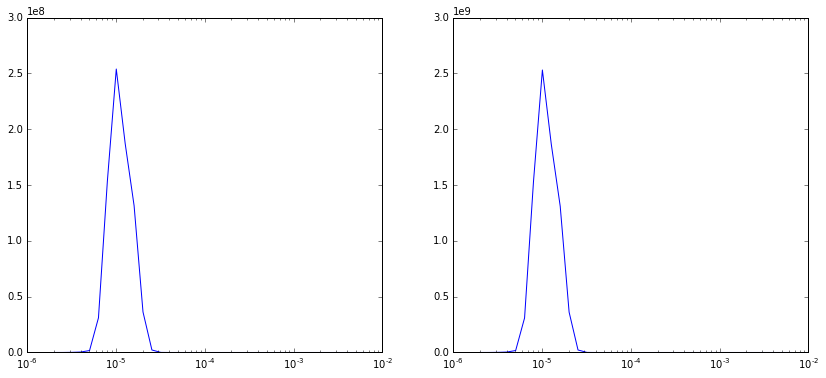

In [146]:
fig = plt.figure(figsize=(14,6))
ax1  = fig.add_subplot(121)
ax1.semilogx(D,nd)
ax2  = fig.add_subplot(122)
ax2.semilogx(D,nd/(np.log10(De[1:]/De[0:-1])))
#plt.semilogx(D,nd)
#plt.semilogx(D,vfall)

In [101]:
print 10.*np.log10(np.sum(nd*(D*1.e3)**6))

-21.932554245


In [102]:
print D.max()
print D.min()

0.00650199
2e-06


In [152]:
#..Let's look at the output from fMRDSS
#filenm = '/home/mvanlier/mvanlier/Posselt_DOE/fmrdss_out_03.nc'
filenm = '/home/mvanlier/mvanlier/Posselt_DOE/fmrdss_out_021600_00.nc'
nc = Dataset(filenm,'r')
vd = nc.variables['doppler_velocity'][:]
#zd = nc.variables['doppler_spectrum'][:]
ds_fm = nc.variables['doppler_spectrum'][:,:]
zc = nc.variables['height'][:]
nc.close()

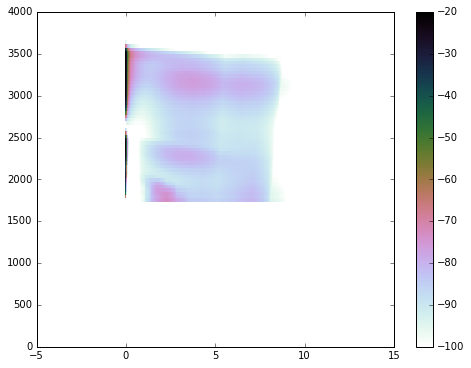

In [95]:
zd = np.ma.masked_where(zd==0,zd)
fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111)
#plt.plot(vd, 10.*np.log10(zd*(vd[2]-vd[1])))
plt.pcolormesh(vd,zc,10.*np.log10(zd*(vd[2]-vd[1])).T,cmap=cm.cubehelix_r,vmin=-100,vmax=-20)
ax.set_xlim(-5,15)
#ax.set_xlim(vd.min(),vd.max())
ax.set_ylim(0,4000)
#plt.plot(vd,zd)
plt.colorbar()

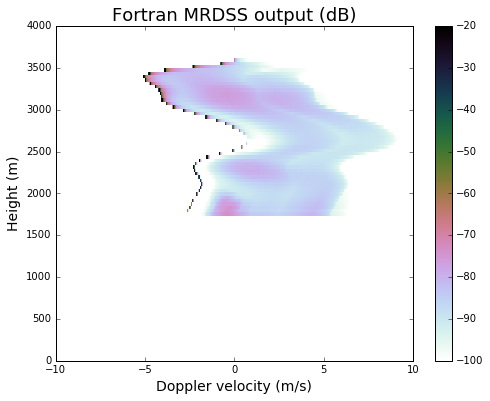

In [154]:
#zd = np.ma.masked_where(zd==0,zd)
fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111)
#plt.plot(vd, 10.*np.log10(zd*(vd[2]-vd[1])))
plt.pcolormesh(vd,zc,10.*np.log10(ds_fm*(vd[2]-vd[1])).T,cmap=cm.cubehelix_r,vmin=-100,vmax=-20)
ax.set_xlim(-10,10)
#ax.set_xlim(vd.min(),vd.max())
ax.set_ylim(0,4000)
#plt.plot(vd,zd)
ax.set_ylabel('Height (m)',fontsize=14)
ax.set_xlabel('Doppler velocity (m/s)',fontsize=14)
plt.title('Fortran MRDSS output (dB)',fontsize=18)
plt.colorbar()

In [128]:
print zd.shape

(768, 145)


In [161]:
print ds_fm.shape

(768, 145)


In [162]:
#..Cacalate moments from this spectrum
dvd = vd[2]-vd[1]
fp_dBz = 10.*np.log10(np.sum(ds_fm*dvd,axis=0))
fp_mdv = copy.deepcopy(fp_dBz)
for i in range(fp_dBz.shape[0]):
    fp_mdv[i] = np.sum(vd*ds_fm[:,i]/np.sum(ds_fm[:,i]))

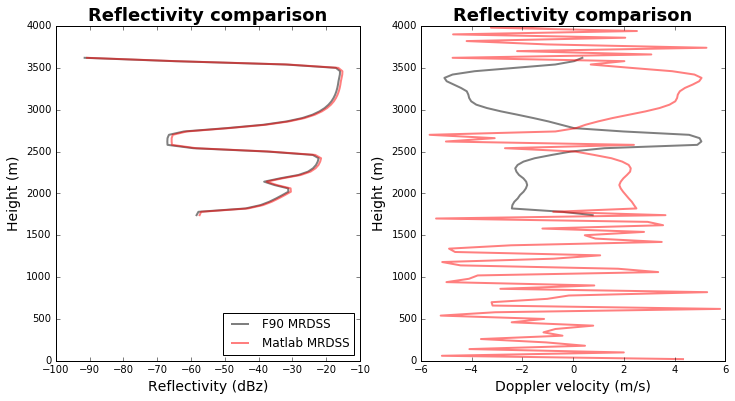

In [166]:
fig = plt.figure(figsize=(12,6))
ax  = fig.add_subplot(121)
ax.plot(fp_dBz,zc,'k',lw=2,label='F90 MRDSS',alpha=.5)
ax.plot(dbz_mie[:,yidx,xidx],zd,'r',lw=2,label='Matlab MRDSS',alpha=.5)
ax.set_xlabel('Reflectivity (dBz)',fontsize=14)
ax.set_ylabel('Height (m)',fontsize=14)
ax.legend(loc=4)
ax.set_ylim(0,4000)
plt.title('Reflectivity comparison',fontsize=18,fontweight='bold')

ax  = fig.add_subplot(122)
ax.plot(fp_mdv,zc,'k',lw=2,label='F90 MRDSS',alpha=.5)
ax.plot(mdv[:,yidx,xidx],zd,'r',lw=2,label='Matlab MRDSS',alpha=.5)
ax.set_xlabel('Doppler velocity (m/s)',fontsize=14)
ax.set_ylabel('Height (m)',fontsize=14)
ax.set_ylim(0,4000)
plt.title('Doppler Velocity',fontsize=18,fontweight='bold')


In [7]:
print 10.*np.log10(zd.sum()*(vd[2]-vd[1]))

-21.4462143251


In [148]:
#..Let's look at the output from Matlab MRDSS
filenm = '/home/mvanlier/mvanlier/Posselt_DOE/simulatedSpectraMRDSS_les_marcus_021600_sgpk-x1.cdf'
nc = Dataset(filenm,'r')
ds_mm = nc.variables['spectra'][207,:,:]
#zd = nc.variables['doppler_spectrum'][:]
nyv = nc.variables['nyquist_velocity'][:]
vd = np.linspace(-nyv,nyv,num=256,endpoint=True)
zc = nc.variables['height'][:]
nc.close()

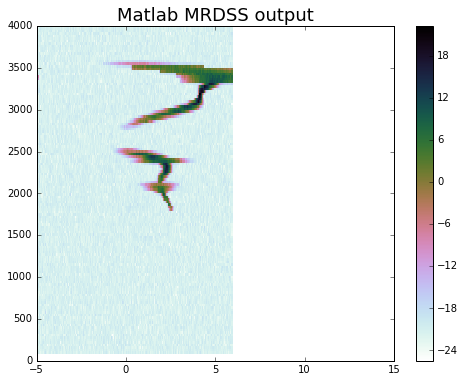

In [149]:
#zd = np.ma.masked_where(zd==0,zd)
fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111)
#plt.plot(vd, 10.*np.log10(zd*(vd[2]-vd[1])))
#plt.pcolormesh(vd,zc,10.*np.log10(zd*(vd[2]-vd[1])).T,cmap=cm.cubehelix_r,vmin=-100,vmax=-20)
plt.pcolormesh(vd,zc,ds_mm,cmap=cm.cubehelix_r)
ax.set_xlim(-5,15)
#ax.set_xlim(vd.min(),vd.max())
ax.set_ylim(0,4000)
#plt.plot(vd,zd)
plt.title('Matlab MRDSS output',fontsize=18)
plt.colorbar()